In [8]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib notebook

# load up dependencies and functions, Note pyGSSHA_functions.py and  GSSHA.exe MUST be in kernal's working dir
%run pyGSSHA_functions.py

Website notes: 
https://dashboard.waterdata.usgs.gov/app/nwd/en/?aoi=state-hi
https://waterdata.usgs.gov/monitoring-location/16611500/#parameterCode=00065&startDT=2022-07-01&endDT=2023-07-01
https://waterdata.usgs.gov/monitoring-location/16611500/#parameterCode=00065&period=P7D

#### Read in Obaserved Rainfallv and stream height Data 

In [9]:
# There needs to be a cell in here that reads in a rainfall file into memory, 
Input_Precip_File = os.path.join(".", "data", "PuuKukuiRain_2022-2023.csv")
Input_Precip_df = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 

### Lovely data cleaning steps
Input_Precip_df = Input_Precip_df.replace(-999999, np.nan)   # Replace all the bunk as no data values 
Input_Precip_df = Input_Precip_df.tz_localize(None).shift(-10, freq='H')         # Scrub out the Timezone awareness of the index

# Clean dataframes a little more
Input_Precip_df = Input_Precip_df[['00045']]
Input_Precip_df.rename(columns={'00045': 'RF_in'}, inplace=True)
Input_Precip_df['RF_mm'] = Input_Precip_df['RF_in']*25.4

# Resample to hourly
Input_Precip_df = Input_Precip_df.resample('60T').sum()



###  read in the Observed stream HEIGHT data too
Input_Stream_df = pd.read_csv(os.path.join(".", "data", 'S_Waiehu_stream_2022-2023.csv'))#.set_index('datetime')
Input_Stream_df['datetime'] = pd.to_datetime(Input_Stream_df['datetime'], errors='coerce')

### Lovely data cleaning steps
Input_Stream_df = Input_Stream_df.replace(-999999, np.nan)
Input_Stream_df.set_index('datetime', inplace=True)
Input_Stream_df = Input_Stream_df.tz_localize(None).shift(-10, freq='H')         # Scrub out the Timezone awareness of the index

#StreamFlow_column_Name = 'SWaiehuFlow'

# and also make a dataframe of the biggest events to use while iterating
#biguns = Biguns_large_event_finder(Input_Stream_df, StreamFlow_column_Name, num_top_events = 30, resample_timestep='1D')

<IPython.core.display.Javascript object>


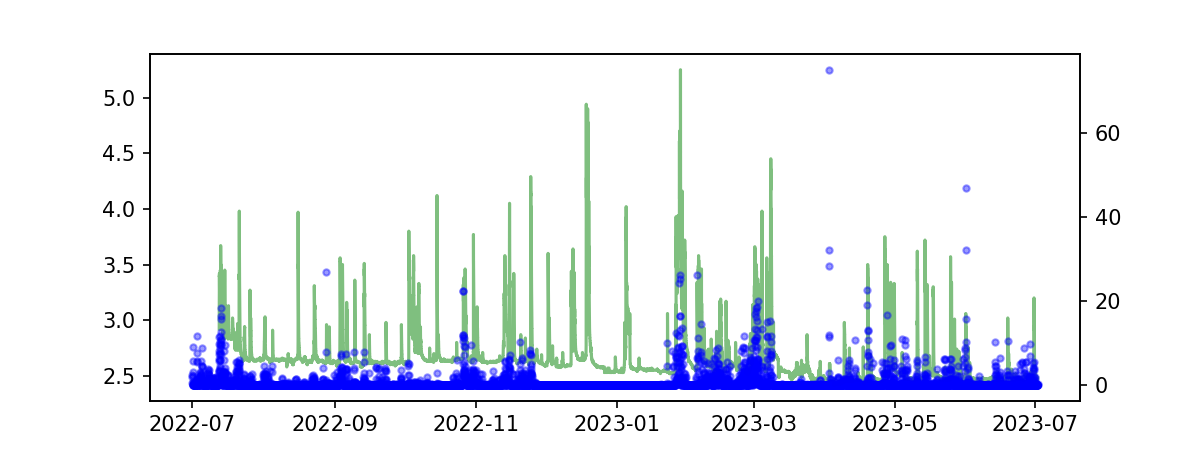

In [10]:
# Plot rainfall and stream height
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()

lns0 = ax2.plot(Input_Precip_df['RF_mm'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(Input_Stream_df['00065'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed


#Good rainfall streamflow events according to graph 
#01-21-2023 - 02-03-2023
#10-25-2022 - 10- 29 2022

#02-26-23 to 3-4-2023
#3-04-23  to 3-06-23
# 11-24-22 to 11-26-23

In [12]:
# Ready  Parameters list 
Code_list_in_WMS = [
    "-104",
"-105",
"-106",
"-107",
"-108",
"-109",
"-1010",
"-1011",
"-1012",
"-1013",
"-1014",
"-1015",
"-1016",
"-1017",
"-1018",
"-1019",
"-1021",
"-1022",
"-1024",
"-1025",
"-201",
"-211",
"-221",
"-231",
"-241",
"-251",
"-261",
"-205",
"-215",
"-225",
"-235",
"-245",
"-255",
"-265",
"-206",
"-216",
"-226",
"-236",
"-246",
"-256",
"-266",
"-207",
"-217",
"-227",
"-237",
"-247",
"-257",
"-267",
"-208",
"-218",
"-228",
"-238",
"-248",
"-258",
"-268",
"-209",
"-219",
"-229",
"-239",
"-249",
"-259",
"-269",
"-2011",
"-2111",
"-2211",
"-2311",
"-2411",
"-2511",
"-2611"]

#Read in frame of base values for all other parameter codes not explicitly modified by the above cell 
Code_Key_df = pd.read_csv(os.path.join('.', 'data', 'Parameter_Codes_SWaiehu_Mod1.csv')) 

# Replicate Runs for multiple Dates events

In [13]:
PrjName = 'v1_50m_SWaiehu_ParamsReady_RUN'
Input_Precip_df = Input_Precip_df
Precip_column_Name = "RF_mm"
# Event Variables 
RainSeries_timestep_Mins = 60
Lat  = "756666.0"      # For Waihehe 753354,    # For WaiehuKou,"758000.0"    # for Iao 753250 # for SWaiehu "756666.0" 
Lon  = "2313888.0"      # For Waihehe 2314472,   # For WaiehuKou,"2315555.0"   # for Iao 2310140 # for SWaiehu "2313888.0" 
RUN_dir = os.path.join('.', 'RUN')

StreamFlow_column_Name = '00065'

# Cell geometry from the WMS model 
NumRowsCells  = 63
NumCols_Cells = 146

dep_file  = os.path.join('.', "RUN", '{}.dep'.format(PrjName))
Cell_to_Extract = [5,145] # [22, 110]

# Each cell is one run 

In [14]:
NSE_LIST = []

### Run 1   "2022-10-25"

<IPython.core.display.Javascript object>


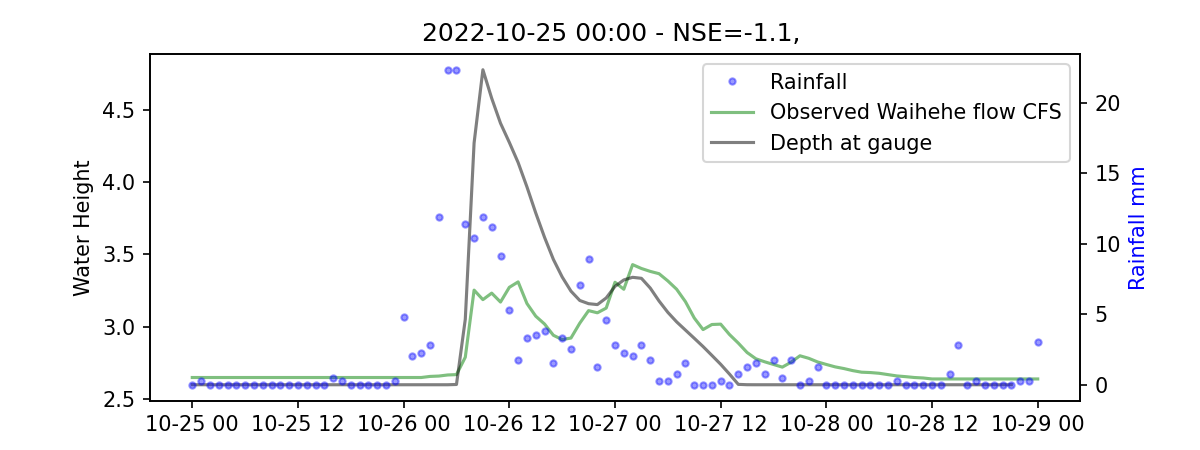

In [15]:
StartDate   =  "2022-10-25 00:00"
EndDate     =    "2022-10-29 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -2)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.6

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

### Run 2   "2023-01-26"

<IPython.core.display.Javascript object>


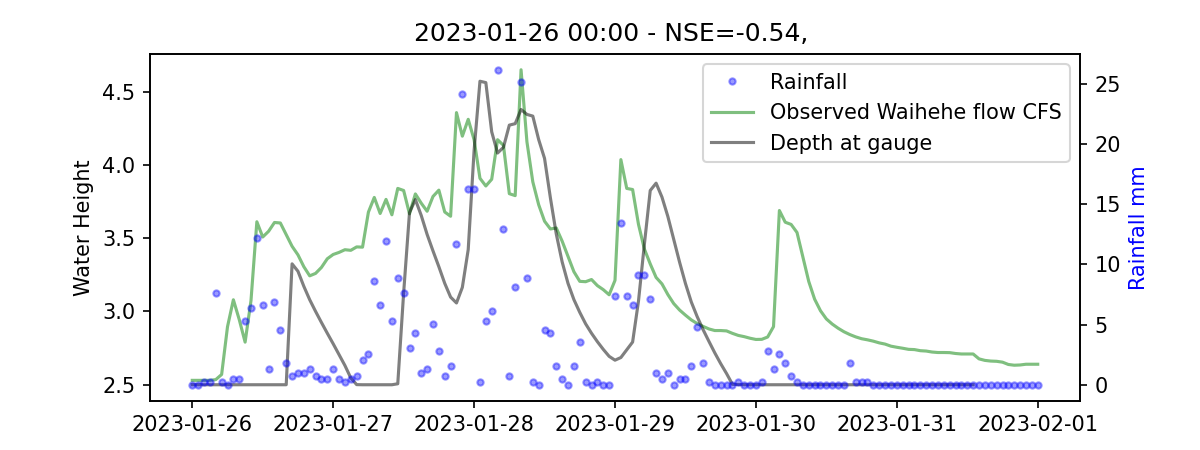

In [16]:
StartDate   =  "2023-01-26 00:00"
EndDate     =    "2023-02-1 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -10)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.5

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

### Run 3  2022-11-24 

<IPython.core.display.Javascript object>


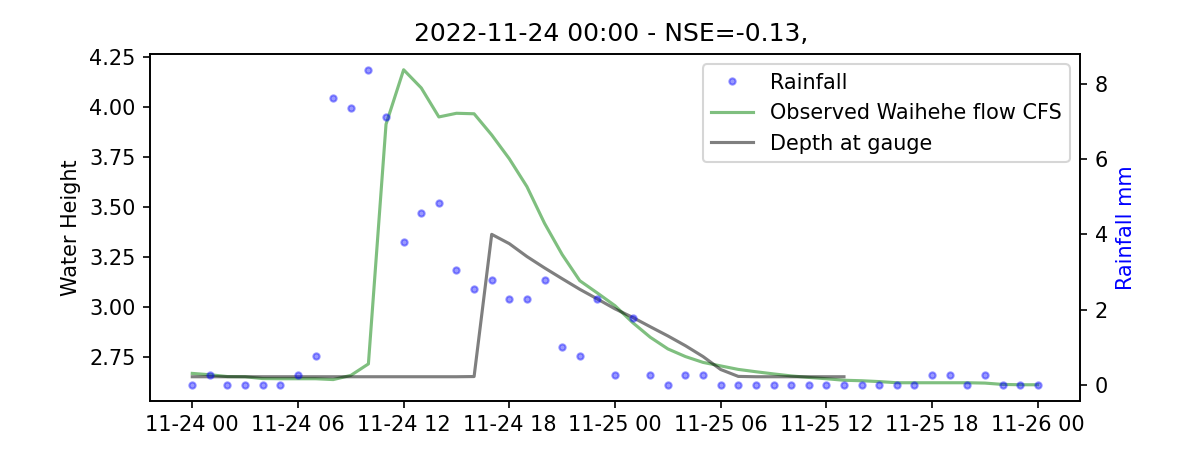

In [17]:
StartDate   =  "2022-11-24 00:00"
EndDate     =    "2022-11-26 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -10)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.65

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

### Run 4  2023-03-06

<IPython.core.display.Javascript object>


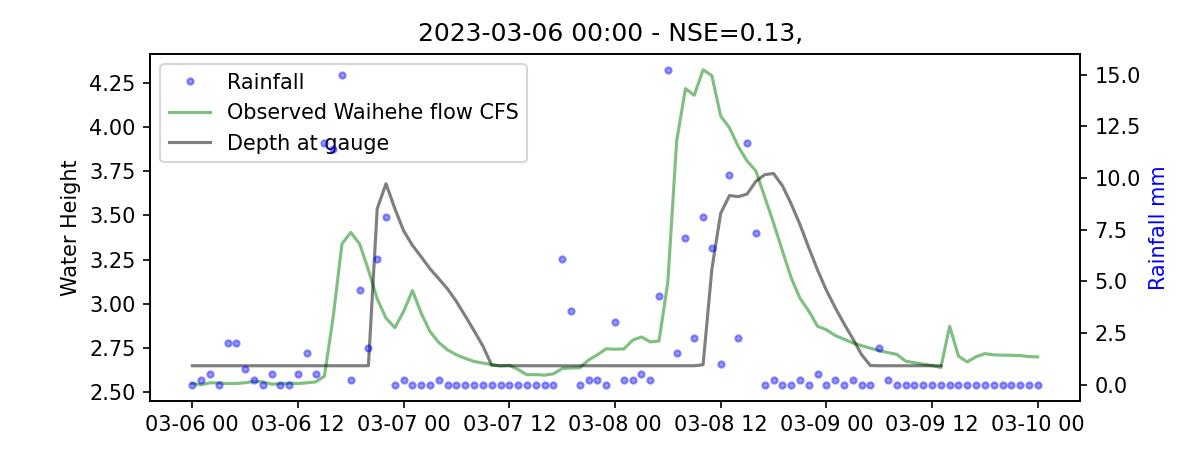

In [18]:
StartDate   =  "2023-03-06 00:00"
EndDate     =    "2023-03-10 00:00"

# Rewrite Gag file and make run length the same as the file 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(PrjName, 
                   Input_Precip_df, Precip_column_Name, StartDate, EndDate, 
                   Lat, Lon, RainSeries_timestep_Mins, ImpPrecip_units="mm")

# use unique start date to create streamflow obs file 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate)

##### RUN GSSHA    ######
elapsed = run_GSSHA(PrjName, RUN_dir)

# Timestep stuff
Timestep_len_mins   = 60
Start_DateTime      = StartDate
# Deal with calculating the number of time steps 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
EndDateTime = datetime.strptime(EndDate, '%Y-%m-%d %H:%M')
Delta = StartDateTime - EndDateTime
Num_steps_in_sim = (abs(Delta.total_seconds())/60)/Timestep_len_mins
NumTS_to_Process    = int(Num_steps_in_sim -10)


# Process the TS map into a depth at one cell 
Depth_Timeseries_df = Process_dep_maps_to_DepthTS_oneCell(dep_file, Cell_to_Extract, NumRowsCells, NumCols_Cells, 
                                       NumTS_to_Process, Timestep_len_mins, Start_DateTime)

# Correction factor needed for this gauge 
Depth_Timeseries_df['Cell_Depth_m'] = Depth_Timeseries_df['Cell_Depth_m'] +2.65

    # Plotting 
# For some reason need to cast the rainfall as a number not object?
Rain_Data_Frame['Rainfall'] = Rain_Data_Frame['Rainfall'].apply(lambda x: float(x)) 
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(Rain_Data_Frame['Rainfall'], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df['Streamflow'], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(Depth_Timeseries_df['Cell_Depth_m'], '-', c='k', alpha=0.5, label="Depth at gauge")   # plot modeled 

ax.set_ylabel("Water Height")
ax2.set_ylabel("Rainfall mm", color='b')
## Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


obs = SlicedStreamflow_df[:len(Depth_Timeseries_df)]['Streamflow']
predictions = Depth_Timeseries_df[:len(Depth_Timeseries_df)]['Cell_Depth_m']
NSE_stat = nse(predictions, obs)

plt.title("{} - NSE={}, ".format(StartDate, round(NSE_stat, 2)))

NSE_LIST.append(NSE_stat)

## Combined NSE

In [19]:
print("the Mean NSE is {}".format(round(np.mean(NSE_LIST),2)))
NSE_LIST

the Mean NSE is -0.41


[-1.103080545194378,
 -0.5401479717942839,
 -0.12747763468981121,
 0.12682514707453252]

In [55]:
THIS IS with soil moisture at .2 

the Mean NSE is -0.44


[-1.2288189805097298,
 -0.5401479717942839,
 -0.12747763468981121,
 0.12682514707453252]

In [48]:
THIS IS with soil moisture at .1 

the Mean NSE is -0.4


[-1.038504773097808,
 -0.5683416809399435,
 -0.15073639014178397,
 0.14113110629272974]

In [42]:
THIS IS with soil moisture at .3 

the Mean NSE is -0.44


[-1.4525658269968371,
 -0.4732140921452159,
 0.02245821987681418,
 0.1453051912318143]